*WebMD* Drug Reviews Dataset;
Dataset of user reviews on various drugs;
https://www.kaggle.com/rohanharode07/webmd-drug-reviews-dataset


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Importing the necessary libraries
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style; style.use('ggplot')
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
import re
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
import seaborn as sns
nltk.download('wordnet')

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data]   Package wordnet is already up-to-date!


True

**Reading the dataset** containing drug names, reviews from the patients, three types of ratings, conditions they are used for etc.
The data is crawled from the www.webmd.com and contains reviews from patients until March 2020.



In [0]:
dataframe = pd.read_csv("/content/drive/My Drive/nlp project dataset/webmd.csv")
dataframe.columns = dataframe.columns.str.lower()
dataframe.head()


,age,condition,date,drug,drugid,easeofuse,effectiveness,reviews,satisfaction,sex,sides,usefulcount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1


In [0]:
df, df_test = train_test_split(dataframe, test_size=0.33, random_state=42) 

In [0]:
print(df.shape)
print(df_test.shape)

(243080, 12)
(119726, 12)


In [0]:
df['date'] = pd.to_datetime(df['date'])
df_test['date'] = pd.to_datetime(df_test['date'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
df['month'] = df.date.apply(lambda i: i.month)
df['day'] = df.date.apply(lambda i: i.day)
df['year'] = df.date.apply(lambda i: i.year)

df_test['month'] = df_test.date.apply(lambda i: i.month)
df_test['day'] = df_test.date.apply(lambda i: i.day)
df_test['year'] = df_test.date.apply(lambda i: i.year)

df['reviewLength'] = df.reviews.apply(lambda x: len(str(x).split()))
df_test['reviewLength'] = df_test.reviews.apply(lambda x: len(str(x).split()))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Removing the outliers in the satisfaction column. The accepted values for this column are from 1 to 5, and there are a few outliers with value 6 and 10.

In [0]:
df['satisfaction'].nunique()

6

In [0]:
print(df.groupby('satisfaction').nunique())


              age  condition  date  drug  ...  month  day  year  reviewLength
satisfaction                              ...                                
1              12       1227  4494  3848  ...     12   31    14           404
2              12        891  3858  2576  ...     12   31    14           369
3              12       1045  3896  2990  ...     12   31    14           377
4              12       1111  4111  3384  ...     12   31    14           395
5              12       1269  4467  4646  ...     12   31    14           412
6               1          1     1     1  ...      1    1     1             1

[6 rows x 16 columns]


In [0]:
print(df[df['satisfaction']==6])


          age            condition       date  ... day  year  reviewLength
195282  35-44  Migraine Prevention 2009-05-18  ...  18  2009            62

[1 rows x 16 columns]


In [0]:
print(df_test[df_test['satisfaction']==10])


          age condition       date  ... day  year  reviewLength
273577  45-54     Other 2013-06-12  ...  12  2013             1

[1 rows x 16 columns]


In [0]:
df.shape, df_test.shape

((243080, 16), (119726, 16))

In [0]:

df = df[df['satisfaction']!=6]
df_test = df_test[df_test['satisfaction']!=6]


In [0]:
df_test = df_test[df_test['satisfaction']!=10]

In [0]:
df.shape, df_test.shape

((243079, 16), (119724, 16))

In [0]:
df.head()

,age,condition,date,drug,drugid,easeofuse,effectiveness,reviews,satisfaction,sex,sides,usefulcount,month,day,year,reviewLength
331277,45-54,Other,2008-05-02,"diltiazem er tablet, extended release 24 hr",3783,5,5,I have used this drug to control my atrial fib...,5,Male,"Dizziness , lightheadedness , weakness , na...",8,5,2,2008,26
227138,45-54,Muscle Spasm,2009-01-30,amrix,148753,5,1,did not control the pain at all,1,Male,"Drowsiness, dizziness , dry mouth , or tired...",2,1,30,2009,7
28510,25-34,Bipolar Depression,2009-01-11,lamictal,8486,3,1,I was on Lamictal for about two months. It mad...,1,Female,"Dizziness , drowsiness, headache , vomiting ...",5,1,11,2009,47
219511,65-74,Major Depressive Disorder,2012-11-20,viibryd,155880,5,5,Major change in my enjoyment of life.\nNo side...,5,Female,"Diarrhea , nausea , vomiting , dizziness , ...",11,11,20,2012,43
153734,45-54,Muscle Spasm,2008-02-20,soma,12153,5,5,this is the only thing that ever work to make ...,5,Female,"Dizziness , drowsiness, or headache may occur.",18,2,20,2008,24


**Preprocessing the data**





In [0]:
from html.parser import HTMLParser

class Handler(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def handle_tags(html):
    s = Handler()
    s.feed(html)
    return s.get_data()

df['reviews'] = df.reviews.apply(lambda x: handle_tags(str(x)))
df_test['reviews'] = df_test.reviews.apply(lambda x: handle_tags(str(x)))

In [0]:
print(df.reviews[5])


help heart condition operation well


In [0]:
# Removing negations

!pip install textsearch
!pip install contractions

import contractions 

df['reviews'] = df['reviews'].map(lambda x: contractions.fix(x))
df_test['reviews'] = df_test['reviews'].map(lambda x: contractions.fix(x))

print(df.reviews[5])

help heart condition operation well


In [0]:
# Lowercasing the reviews

df['reviews'] = df['reviews'].map(lambda x: x.lower())
df_test['reviews'] = df_test['reviews'].map(lambda x: x.lower())

# Removing numbers
import re

df['reviews'] = df['reviews'].map(lambda x: re.sub(r'\d+', '', x))
df_test['reviews'] = df_test['reviews'].map(lambda x: re.sub(r'\d+', '', x))

# Deleting interpunction and special characters
df['reviews'] = df['reviews'].map(lambda x: re.sub('[!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~]', '', x))
df_test['reviews'] = df_test['reviews'].map(lambda x: re.sub('[!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~]', '', x))


print(df.reviews[5])

help heart condition operation well


In [0]:
# Lemmatization

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer=WordNetLemmatizer()

df['reviews'] = df['reviews'].map(lambda x: ' '.join(lemmatizer.lemmatize(word, pos="v") for word in word_tokenize(x)))
df_test['reviews'] = df_test['reviews'].map(lambda x: ' '.join(lemmatizer.lemmatize(word, pos="v") for word in word_tokenize(x)))

df['reviews'] = df['reviews'].map(lambda x: ' '.join(lemmatizer.lemmatize(word, pos="n") for word in word_tokenize(x)))
df_test['reviews'] = df_test['reviews'].map(lambda x: ' '.join(lemmatizer.lemmatize(word, pos="n") for word in word_tokenize(x)))

print(df.reviews[5])

help heart condition operation well


In [0]:
# removing stopwords
from nltk.corpus import stopwords
stopword = stopwords.words('english')

df['reviews'] = df['reviews'].map(lambda x: ' '.join(word for word in word_tokenize(x) if word not in stopword))
df_test['reviews'] = df_test['reviews'].map(lambda x: ' '.join(word for word in word_tokenize(x) if word not in stopword))

print(df.reviews[5])

help heart condition operation well


**Topic Modeling** 

In [0]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

all = pd.concat([df.iloc[:,0:11], df_test])

Word cloud based on all drug reviews


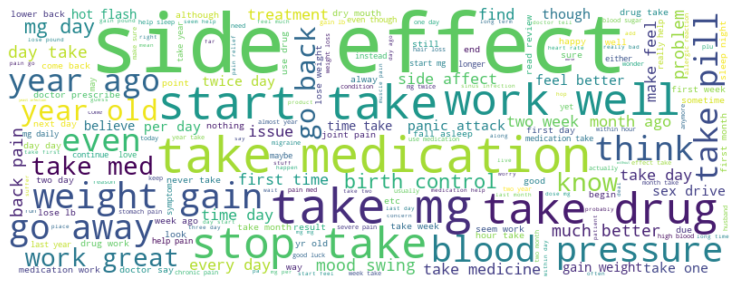

In [0]:
#Word cloud based on words in all drug reviews
text = " ".join(review for review in all.reviews)
# creating a word cloud image:
wordcloud = WordCloud(width=800, height=300,background_color="white").generate(text)
plt.figure(figsize=(20,5))
# show the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Word cloud based on 'Pain' drug reviews



For the medical condition listed as 'Pain' there are 3256664 words combined.


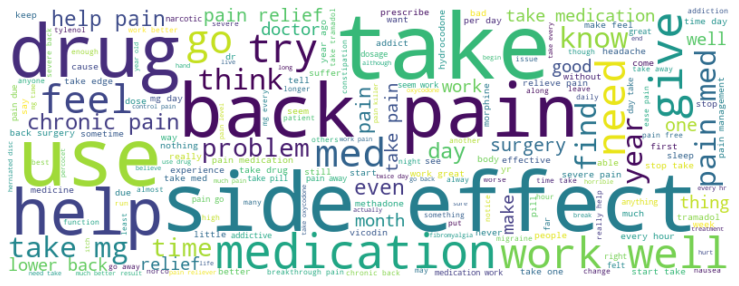

In [0]:

string = " ".join(review for review in all[all.condition=='Pain'].reviews)

print ("For the medical condition listed as 'Pain' there are {} words combined.".format(len(string)))

wordcloud = WordCloud(width=800, height=300,background_color="white").generate(string)

plt.figure(figsize=(20,5))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Word cloud based on 'Acne' drug reviews


For the medical condition listed as 'Acne' there are 609149 words combined.


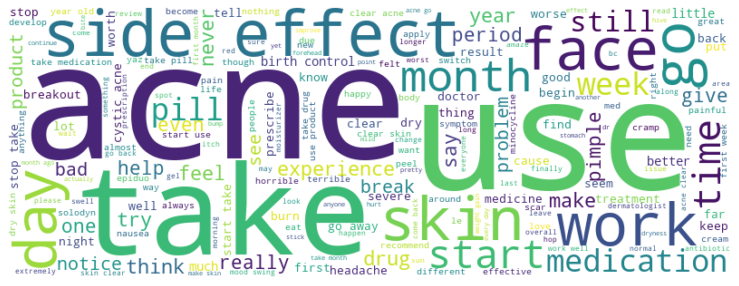

In [0]:
string = " ".join(review for review in all[all.condition=='Acne'].reviews)
print ("For the medical condition listed as 'Acne' there are {} words combined.".format(len(string)))

wordcloud = WordCloud(width=800, height=300,background_color="white").generate(string)
plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Topic Modeling - removing stopwords

In [0]:
# delete drug names
new_set = set(all.drug.tolist())
new_set = {i.lower() for i in new_set}
new_list=[]
for i in new_set:
    good = i.split()
    new_list.extend(good)
new_set=set(new_list)
verbs = ['take', 'get', 'go', 'work', 'start', 'day', 'days', 'feel', 'time', 'year', 'month', 'years', 'months', 'mg', 'like', 'would', 'use',\
         'first', 'try', 'doctor', 'pill', 'week', 'dose', 'lb', 'hour', 'one', 'never']

all = all.copy()
all['reviews'] = all.reviews.map(lambda x: ' '.join(word for word in word_tokenize(x) if word not in verbs))
all['reviews'] = all.reviews.map(lambda x: ' '.join(word for word in word_tokenize(x) if word not in new_set))

In [0]:
%%time

# Loading the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function for printing
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic  - %d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 16.2 µs


In [0]:
count_vectorizer = CountVectorizer()
vectorized_data = count_vectorizer.fit_transform(all[all.condition=='Pain'].reviews)
number_topics = 3
number_words = 8
lda = LDA(n_components=number_topics, n_jobs=-1, random_state=1)
lda.fit(vectorized_data)
# Topics found by the LDA model
print("Topics found with LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found with LDA:

Topic  - 0:
med drug need surgery help every life give

Topic  - 1:
help med drug well also problem find effect

Topic  - 2:
drug help make effect side give well good


In [0]:
vectorized_data = count_vectorizer.fit_transform(all[all.condition=='Acne'].reviews)
number_topics = 3
number_words = 8
lda = LDA(n_components=number_topics, n_jobs=-1, random_state=55566)
lda.fit(vectorized_data)
# Topics found by the LDA model
print("Topics found with LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found with LDA:

Topic  - 0:
make side effect period help also experience bad

Topic  - 1:
drug also see think effect side stomach notice

Topic  - 2:
product really pimple effect see peel apply drug


In [0]:
vectorized_data = count_vectorizer.fit_transform(all[all.condition=='Depression'].reviews)
number_topics = 3
number_words = 8
lda = LDA(n_components=number_topics, n_jobs=-1, random_state=55566)
lda.fit(vectorized_data)
# Topics found by the LDA model
print("Topics found with LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found with LDA:

Topic  - 0:
help make better life depression felt thing think

Topic  - 1:
depression effect side drug help anxiety also life

Topic  - 2:
drug med effect side weight generic gain know


In [0]:
vectorized_data = count_vectorizer.fit_transform(all[all.condition=='Birth Control'].reviews)
number_topics = 3
number_words = 8
lda = LDA(n_components=number_topics, n_jobs=-1, random_state=55566)
lda.fit(vectorized_data)
# Topics found by the LDA model
print("Topics found with LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found with LDA:

Topic  - 0:
switch make birth gain swing period also cry

Topic  - 1:
side effect blood birth switch experience drug tell

Topic  - 2:
period birth side effect weight gain bleed experience


In [0]:
vectorized_data = count_vectorizer.fit_transform(all[all.condition=='High Blood Pressure'].reviews)
number_topics = 3
number_words = 8
lda = LDA(n_components=number_topics, n_jobs=-1, random_state=55566)
lda.fit(vectorized_data)
# Topics found by the LDA model
print("Topics found with LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found with LDA:

Topic  - 0:
pressure blood side effect drug lower problem good

Topic  - 1:
med side effect weight drug swell problem gain

Topic  - 2:
drug also leg swell med cause side develop


In [0]:
vectorized_data = count_vectorizer.fit_transform(all[all.condition=='Neuropathic Pain'].reviews)
number_topics = 3
number_words = 8
lda = LDA(n_components=number_topics, n_jobs=-1, random_state=55566)
lda.fit(vectorized_data)
# Topics found by the LDA model
print("Topics found with LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found with LDA:

Topic  - 0:
help side effect make drug nerve med also

Topic  - 1:
med help drug gain weight nerve problem could

Topic  - 2:
drug side effect help leg much neuropathy also


In [0]:
vectorized_data = count_vectorizer.fit_transform(all[all.condition=='Migraine Prevention'].reviews)
number_topics = 3
number_words = 8
lda = LDA(n_components=number_topics, n_jobs=-1, random_state=55566)
lda.fit(vectorized_data)
# Topics found by the LDA model
print("Topics found with LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found with LDA:

Topic  - 0:
side effect drug help weight loss since lose

Topic  - 1:
help side lose effect also medicine find drug

Topic  - 2:
side effect med make experience loss also tingle


In [0]:
vectorized_data = count_vectorizer.fit_transform(all[all.condition=='Type 2 Diabetes Mellitus'].reviews)
number_topics = 3
number_words = 8
lda = LDA(n_components=number_topics, n_jobs=-1, random_state=55566)
lda.fit(vectorized_data)
# Topics found by the LDA model
print("Topics found with LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found with LDA:

Topic  - 0:
effect side drug problem stomach blood experience cause

Topic  - 1:
weight blood gain drug lose good med better

Topic  - 2:
level blood eat drug help morning med drop


In [0]:
vectorized_data = count_vectorizer.fit_transform(all[all.condition=='Chronic Trouble Sleeping'].reviews)
number_topics = 3
number_words = 8
lda = LDA(n_components=number_topics, n_jobs=-1, random_state=55566)
lda.fit(vectorized_data)
# Topics found by the LDA model
print("Topics found with LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found with LDA:

Topic  - 0:
asleep fall wake help effect side drug every

Topic  - 1:
wake drug well effect remember side make thing

Topic  - 2:
drug make still find help could nothing give


In [0]:
vectorized_data = count_vectorizer.fit_transform(all[all.condition=='High Cholesterol'].reviews)
number_topics = 3
number_words = 8
lda = LDA(n_components=number_topics, n_jobs=-1, random_state=55566)
lda.fit(vectorized_data)
# Topics found by the LDA model
print("Topics found with LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found with LDA:

Topic  - 0:
side effect drug leg lower med bad also

Topic  - 1:
ldl effect side statin level lower diet hdl

Topic  - 2:
drug problem side statin effect leg could experience


In [0]:
vectorized_data = count_vectorizer.fit_transform(all[all.condition=='Anxious'].reviews)
number_topics = 3
number_words = 8
lda = LDA(n_components=number_topics, n_jobs=-1, random_state=55566)
lda.fit(vectorized_data)
# Topics found by the LDA model
print("Topics found with LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found with LDA:

Topic  - 0:
anxiety effect side help calm great also med

Topic  - 1:
anxiety help attack panic prescribe drug much need

Topic  - 2:
anxiety drug help need make give well really


In [0]:
vectorized_data = count_vectorizer.fit_transform(all[all.condition=='Muscle Spasm'].reviews)
number_topics = 3
number_words = 8
lda = LDA(n_components=number_topics, n_jobs=-1, random_state=55566)
lda.fit(vectorized_data)
# Topics found by the LDA model
print("Topics found with LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found with LDA:

Topic  - 0:
make drug spasm help effect give side really

Topic  - 1:
spasm help medicine effect well side neck med

Topic  - 2:
spasm help med leg drug prescribe effect lower


In [0]:
vectorized_data = count_vectorizer.fit_transform(all[all.condition=='Cough'].reviews)
number_topics = 3
number_words = 8
lda = LDA(n_components=number_topics, n_jobs=-1, random_state=55566)
lda.fit(vectorized_data)
# Topics found by the LDA model
print("Topics found with LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found with LDA:

Topic  - 0:
help bad medicine prescribe make could really med

Topic  - 1:
prescribe drug help nothing bronchitis waste money med

Topic  - 2:
effect side make medicine much help well felt


In [0]:
vectorized_data = count_vectorizer.fit_transform(all[all.condition=='Overweight'].reviews)
number_topics = 3
number_words = 8
lda = LDA(n_components=number_topics, n_jobs=-1, random_state=55566)
lda.fit(vectorized_data)
# Topics found by the LDA model
print("Topics found with LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found with LDA:

Topic  - 0:
lose weight eat pound exercise diet help make

Topic  - 1:
help well two know med eat need side

Topic  - 2:
lose side effect drug pound anyone weight know


In [0]:
vectorized_data = count_vectorizer.fit_transform(all[all.condition=='Chickenpox'].reviews)
number_topics = 3
number_words = 10
lda = LDA(n_components=number_topics, n_jobs=-1, random_state=55566)
lda.fit(vectorized_data)
# Topics found by the LDA model
print("Topics found with LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found with LDA:

Topic  - 0:
herpes osato herb also world testify miss kind keep hsv

Topic  - 1:
atm card john money mr machine blank contact directly withdraw

Topic  - 2:
chickenpox still pox think become generally contagious hear definitely prescribe


In [0]:
vectorized_data = count_vectorizer.fit_transform(all[all.condition=='Cold Symptoms'].reviews)
number_topics = 3
number_words = 10
lda = LDA(n_components=number_topics, n_jobs=-1, random_state=55566)
lda.fit(vectorized_data)
# Topics found by the LDA model
print("Topics found with LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found with LDA:

Topic  - 0:
medicine effect help side even symptom drug better also hurt

Topic  - 1:
make felt help side effect recommend dizzy great symptom stomach

Topic  - 2:
three effect side symptom well stuffy full prescribe see drainage


**Conclusion for topic modeling**

It makes sense for most of the words to be correlated with the specific medical condition that has been reviewed by the patient, but still we can look at them as individual words that do not contribute with information about the meaning of the review associated with the condition and draw the bigger picture.


**Collocation**
A collocation is a sequence of words or terms that co-occur more often than would be expected by chance.

In [0]:

df = df[df['satisfaction']!=6]
df_test = df_test[df_test['satisfaction']!=6]


In [0]:
reviews_df = dataframe[dataframe.apply(lambda srs: pd.notnull(srs['reviews']) and (get_language(srs['reviews']) == 'english'), axis='columns')]

In [0]:
example_listing_reviews = reviews_df.query('1181')


In [0]:
len(example_listing_reviews)


12

In [0]:
from nltk import word_tokenize


In [0]:
example_listing_reviews

age                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            35-44
condition                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [0]:
#words = np.concatenate(np.array([word_tokenize(r) for r in example_listing_reviews['reviews'].values]))
words = np.concatenate([np.array(word_tokenize(example_listing_reviews['reviews']))])

In [0]:
words


array(['I', 'started', 'taking', 'this', 'a', 'few', 'days', 'ago', ',',
       'and', 'as', 'I', 'write', 'this', 'I', 'am', 'having', 'a',
       'hard', 'time', 'writing', '.', 'I', 'can', 'barely', 'think', '.',
       'I', 'left', 'my', 'apt', '.', 'to', 'go', 'to', 'a', 'friends',
       'apt', 'just', 'two', 'buildings', 'over', 'and', 'as', 'I',
       'started', 'walking', 'I', 'started', 'hallucinating', 'and', 'it',
       'felt', 'like', 'the', 'snow', 'was', 'a', 'moving', 'escalator',
       'under', 'my', 'feet', 'it', 'made', 'me', 'fall', 'flat', 'on',
       'my', 'face', 'in', 'the', 'snow', '.', 'I', 'had', 'to', 'roll',
       'over', 'to', 'get', 'up', 'and', 'practically', 'crawled', 'in',
       'the', 'snow', 'home', '.', 'I', 'take', '150', 'my', 'twice', 'a',
       'day', 'and', 'it', 'is', '4', 'am', 'and', 'I', 'am', 'awake',
       'and', 'can', 'not', 'fall', 'asleep', '.', 'I', 'have', 'a',
       'sick', '6', 'year', 'old', 'son', 'to', 'take', 'care',

In [0]:
from nltk.collocations import BigramAssocMeasures, TrigramAssocMeasures, BigramCollocationFinder

bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(words)

finder.apply_freq_filter(3) 
finder.nbest(bigram_measures.pmi, 10)  

[('the', 'snow'), ('I', 'started'), ('.', 'I'), ('I', 'am')]

Let's have a look at how many reviews there are per drug:





In [0]:
reviews_df.head()

,age,condition,date,drug,drugid,easeofuse,effectiveness,reviews,satisfaction,sex,sides,usefulcount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I have tried for my allergies (seasonal and not) - this one is the most effective for me. When I first began using this drug some years ago - tiredness as a problem but is not currently.,5,Male,"Drowsiness, dizziness , dry mouth /nose/throat, headache , upset stomach , constipation , or trouble sleeping may occur.",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurting it went away after taking the medicine,5,Female,"Drowsiness, dizziness , dry mouth /nose/throat, headache , upset stomach , constipation , or trouble sleeping may occur.",1
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to over \n100?,3,Female,,0
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,"My grandfather was prescribed this medication (Coumadin) to assist in blood thinning due to a heart and thyroid condition. His primary doctor was aware that he was on an aspirin regiment and still prescribed this medicine, it caused his blood to thin out to much and he ended up internally bleeding to death. If you are going to take this medicine please ask your doctors about possible side effects or drug interactions.",1,Male,,1


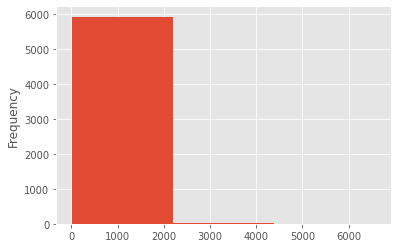

In [0]:
reviews_df.groupby('drugid')['reviews'].count().plot(kind='hist', bins=3)

Next step is using BigramCollocationFinder. It expects tokenized text as separate words from the reviews.

In [0]:
review_words = reviews_df.groupby('drugid').apply(
    lambda df: np.concatenate(np.array([word_tokenize(r) for r in df['reviews'].values]))
)

In [0]:
import string

ex = ['Hi', 'there', '.', '?', '!', ',']
[w for w in ex if w not in string.punctuation]

['Hi', 'there']

In [0]:
review_words_f = review_words.map(lambda arr: np.array([w for w in arr if w not in string.punctuation]))


In [0]:
review_words_f.head()


drugid
1     [Started, taking, it, as, an, add, on, to, bupropion, 300XL, which, had, started, to, loose, effectiveness, for, my, depression, 25, mgs, did, n't, do, much, but, 50, mgs, did, help, I, found, the, sexual, side, effects, to, be, very, real, and, am, making, a, trade, off, between, depression, and, a, sex, life, I, ’, ve, been, on, sertraline, a, little, over, a, year, now, and, I, ’, m, generally, happy, with, the, drug, I, ’, ve, had, depression, and, anxiety, as, long, as, I, can, remember...
9     [I, got, 5, injections, in, my, back, at, onece, for, lower, back, pain, The, was, horrible, and, it, did, n't, help, I, had, no, relief, at, all, Had, this, treatment, for, my, lower, back, pain, I, did, n't, notice, any, difference, in, pain, level, I, had, Lichen, Planus, Blisters, on, my, hands, and, feet, due, to, it, there, was, inflammation, redness, itchiness, on, my, hands, and, feet, By, using, this, injection, i, got, rid, of, itchiness, and, burning, but, side, eff

In [0]:
def reattach_contractions(wordlist):
    words = []
    for i, word in enumerate(wordlist):
        if word[0] == "'" or word == "n't":
            words[-1] = words[-1] + word
        else:
            words.append(word)
    return words

In [0]:
review_words_f = review_words_f.map(reattach_contractions)


This function looks for bigrams that appear in the texts >= 3 times, and chooses the ones with larger value for pmi (pointwise mutual information).

In [0]:
# from nltk.collocations import BigramAssocMeasures, TrigramAssocMeasures, BigramCollocationFinder

def bigramify(words):
    finder = BigramCollocationFinder.from_words(words)
    finder.apply_freq_filter(3) 
    return finder.nbest(bigram_measures.pmi, 3)

review_bigrams = review_words_f.map(bigramify)

Results 


In [0]:
review_bigrams.head(20)


drugid
1             [(canâ, t), (blurred, vision), (blood, pressure)]
9          [(associated, with), (lower, back), (side, effects)]
17                    [(urgent, care), (did, not), (pink, eye)]
18                    [(..., .LOOK), (.LOOK, AT), (AND, MOUTH)]
30                 [(other, drugs), (year, old), (worse, than)]
34               [(bone, marrow), (40,000, units), (below, 12)]
35           [(fish, oil), (metaphorically, -Her), (-Her, Mom)]
37      [(long, term), (blood, transfusion), (Peg, Interferon)]
38                       [(heart, rate), (my, heart), (for, a)]
45                                               [(mild, acne)]
49     [(Questran, Light), (chronic, diarrhea), (been, taking)]
50                                                           []
52                                                           []
56                                                           []
63              [(Good, luck), (rotator, cuff), (mood, swings)]
64                               

Interesting correlations that make sense

In [0]:
def sample_reviews(drugid):
    bigrams = review_bigrams[drugid]
    review_texts = dataframe[dataframe['drugid'] == drugid]['reviews'].values
    sample_reviews = []
    for bigram in bigrams:
        sample_review_list = list(filter(lambda txt: " ".join(bigram) in txt, review_texts))
        num_reviews = len(sample_review_list)
        sample_review = sample_review_list[0]
        sample_review = sample_review.replace(" ".join(bigram), "****" + " ".join(bigram) + "****")
        start_index = sample_review.index("****")
        sample_text = "..." + sample_review[start_index - 47: start_index + 47] + "..."
        sample_reviews.append(sample_text)
    return sample_reviews

We can label them as meaningful collocation bigrams right in the reviews.

In [0]:
for review in sample_reviews(73):
    print(review)

...for my sinus congestion, but since I also have ****Granuloma Annulare**** with itching, the do...
......
...facturer.  Although it states that it does not ****cause drowsiness****, I found, like all oth...


In [0]:
for review in sample_reviews(17):
    print(review)

......
...****did not**** help my condition...
...was a nice benefit. These drops cleared up the ****pink eye**** in three days but my Dr told m...


Collocation with nltk works really good! It turns out to be something that's pretty easy to do but which generates reasonably good results. It is a useful tool for marking important information in the reviews, even if we are just reading it is pretty useful if the important parts from the reviews stand out somehow (for example, are marked in bold text) which helps us, as humans extract information more quickly and find what out what is important in a particular review and what interests us about the medication.

In [0]:
reviews = pd.read_csv("/content/drive/My Drive/nlp project dataset/webmd.csv")
reviews.columns = reviews.columns.str.lower()
reviews.head(2)

,age,condition,date,drug,drugid,easeofuse,effectiveness,reviews,satisfaction,sex,sides,usefulcount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I have tried for my allergies (seasonal and not) - this one is the most effective for me. When I first began using this drug some years ago - tiredness as a problem but is not currently.,5,Male,"Drowsiness, dizziness , dry mouth /nose/throat, headache , upset stomach , constipation , or trouble sleeping may occur.",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurting it went away after taking the medicine,5,Female,"Drowsiness, dizziness , dry mouth /nose/throat, headache , upset stomach , constipation , or trouble sleeping may occur.",1


In [0]:
comments = reviews['reviews']


Preprocessing the reviews


In [0]:

#function to remove non-ascii characters
def _removeNonAscii(s): return "".join(i for i in s if ord(i)<128)

In [0]:
comments = comments.astype('str')


In [0]:
#remove non-ascii characters
comments = comments.map(lambda x: _removeNonAscii(x))

In [0]:
#get stop words of all languages
STOPWORDS_DICT = {lang: set(nltk.corpus.stopwords.words(lang)) for lang in nltk.corpus.stopwords.fileids()}


In [0]:

#function to detect language based on # of stop words for particular language
def get_language(text):
    words = set(nltk.wordpunct_tokenize(text.lower()))
    lang = max(((lang, len(words & stopwords)) for lang, stopwords in STOPWORDS_DICT.items()), key = lambda x: x[1])[0]
    if lang == 'english':
        return True
    else:
        return False

In [0]:
#filter for only english comments
eng_comments=comments[comments.apply(get_language)]

In [0]:
eng_comments.head()


0                                                                                                                                                                                                    I'm a retired physician and of all the meds I have tried for my allergies (seasonal and not) - this one is the most effective for me.  When I first began using this drug some years ago - tiredness as a problem but is not currently.
1                                                                                                                                                                                                                                                                                                                                                     cleared me right up even with my throat hurting it went away after taking the medicine
2                                                                                                                                             

In [0]:

#drop duplicates
eng_comments.drop_duplicates(inplace=True)

In [0]:
#load all libraries
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import spacy
import string

In [0]:

#load spacy
nlp = spacy.load('en')

In [0]:

#function to clean and lemmatize comments
def clean_comments(text):
    #remove punctuations
    regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
    nopunct = regex.sub(" ", str(text))
    #use spacy to lemmatize comments
    doc = nlp(nopunct, disable=['parser','ner'])
    lemma = [token.lemma_ for token in doc]
    return lemma

In [0]:

#apply function to clean and lemmatize comments
lemmatized = eng_comments.map(clean_comments)

In [0]:

#make sure to lowercase everything
lemmatized = lemmatized.map(lambda x: [word.lower() for word in x])

In [0]:
lemmatized.head()


0                                                                                                                                                                                                             [-pron-, m, a, retire, physician, and, of, all, the, med, -pron-, have, try, for, -pron-, allergy,  , seasonal, and, not,    , this, one, be, the, most, effective, for, -pron-,   , when, -pron-, first, begin, use, this, drug, some, year, ago,   , tiredness, as, a, problem, but, be, not, currently]
1                                                                                                                                                                                                                                                                                                                                                                                                             [clear, -pron-, right, up, even, with, -pron-, throat, hurt, -pron-, go, away, after, take, the, 

In [0]:
#turn all comments' tokens into one single list
unlist_comments = [item for items in lemmatized for item in items]

Initialize NLTK's Bigrams/Trigrams Finder

In [0]:
bigrams = nltk.collocations.BigramAssocMeasures()
trigrams = nltk.collocations.TrigramAssocMeasures()

In [0]:

bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(unlist_comments)
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(unlist_comments)

1. Counting Frequencies of Adjacent Words
Main idea: simply order by frequency
Issues: too sensitive to very frequent pairs and pronouns/articles/prepositions come up often
Solution: filter for only adjectives and nouns

In [0]:
bigram_freq = bigramFinder.ngram_fd.items()


In [0]:

bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)

In [0]:
bigramFreqTable.head().reset_index(drop=True)


,bigram,freq
0,"( , -pron-)",386101
1,"(-pron-, be)",217660
2,"(-pron-, have)",207470
3,"( , -pron-)",154634
4,"(and, -pron-)",97795


In [0]:
bigramFreqTable[:10]


,bigram,freq
123,"( , -pron-)",386101
113,"(-pron-, be)",217660
10,"(-pron-, have)",207470
106,"( , -pron-)",154634
133,"(and, -pron-)",97795
754,"(have, be)",66583
353,"( , and)",66576
154,"(side, effect)",60332
254,"(-pron-, )",59553
783,"( , but)",59414


In [0]:
#get english stopwords
en_stopwords = set(stopwords.words('english'))

In [0]:
#function to filter for ADJ/NN bigrams
def rightTypes(ngram):
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords:
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False

In [0]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:

#filter bigrams
filtered_bi = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x))]

In [0]:
filtered_bi[:10]


,bigram,freq
154,"(side, effect)",60332
660,"(weight, gain)",8522
1531,"(blood, pressure)",8429
377,"(birth, control)",6899
325,"(mood, swing)",5765
2686,"(effect, )",5710
2334,"(year, )",5656
2774,"(pain, )",4924
2324,"(drug, )",4500
1428,"(month, )",4464


In [0]:
trigram_freq = trigramFinder.ngram_fd.items()


In [0]:

trigramFreqTable = pd.DataFrame(list(trigram_freq), columns=['trigram','freq']).sort_values(by='freq', ascending=False)

In [0]:
trigramFreqTable.head().reset_index(drop=True)


,trigram,freq
0,"( , -pron-, have)",62039
1,"( , -pron-, be)",59456
2,"(-pron-, have, be)",40175
3,"( , -pron-, have)",26515
4,"( , -pron-, be)",24597


In [0]:
trigramFreqTable[:10]


,trigram,freq
112,"( , -pron-, have)",62039
91,"( , -pron-, be)",59456
540,"(-pron-, have, be)",40175
466,"( , -pron-, have)",26515
367,"( , -pron-, be)",24597
148,"(-pron-, , -pron-)",23363
814,"( , but, -pron-)",21499
1548,"( , and, -pron-)",17758
590,"(have, be, on)",15860
607,"(-pron-, don, t)",15528


In [0]:
def rightTypesTri(ngram):
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or '  ' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords:
            return False
    first_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    third_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in first_type and tags[2][1] in third_type:
        return True
    else:
        return False

In [0]:
filtered_tri = trigramFreqTable[trigramFreqTable.trigram.map(lambda x: rightTypesTri(x))]


In [0]:
filtered_tri[:10]


,trigram,freq
5080,"(high, blood, pressure)",1960
9816,"(bad, side, effect)",1870
6518,"(mg, per, day)",952
394,"(birth, control, pill)",892
3584,"(low, back, pain)",876
7942,"(negative, side, effect)",840
4716,"(many, side, effect)",777
9472,"(horrible, side, effect)",733
19554,"(flu, like, symptom)",711
36772,"(sexual, side, effect)",650


In [0]:
freq_bi = filtered_bi[:20].bigram.values


In [0]:
freq_tri = filtered_tri[:20].trigram.values


2. PMI

In [0]:
bigramFinder.apply_freq_filter(20)


In [0]:
bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)

In [0]:
bigramPMITable[:10]


,bigram,PMI
0,"(alka, seltzer)",19.340328
1,"(519, 0838)",19.220034
2,"(garcinia, cambogia)",19.131029
3,"(pseudotumor, cerebri)",18.974922
4,"(tubal, ligation)",18.250966
5,"(polymyalgia, rheumatica)",18.000220
6,"(tessalon, perles)",17.995680
7,"(lichen, planus)",17.992624
8,"(eli, lilly)",17.963886
9,"(pepto, bismol)",17.818318


In [0]:
trigramFinder.apply_freq_filter(20)


In [0]:
trigramPMITable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.pmi)), columns=['trigram','PMI']).sort_values(by='PMI', ascending=False)

In [0]:
trigramPMITable[:10]


,trigram,PMI
0,"(reflex, sympathetic, dystrophy)",34.022478
1,"(apple, cider, vinegar)",33.700288
2,"(mitral, valve, prolapse)",32.116538
3,"(osatoherbalcure, wordpress, com)",30.975836
4,"(proton, pump, inhibitor)",30.469614
5,"(stevens, johnson, syndrome)",30.138519
6,"(herpes, simplex, virus)",29.287413
7,"(non, hodgkins, lymphoma)",29.276125
8,"(ehigieherbalcure, gmail, com)",29.179227
9,"(cottage, cheese, discharge)",29.053794


In [0]:
pmi_bi = bigramPMITable[:20].bigram.values


In [0]:
pmi_tri = trigramPMITable[:20].trigram.values


3. t-test

In [0]:

bigramTtable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.student_t)), columns=['bigram','t']).sort_values(by='t', ascending=False)

In [0]:
bigramTtable.head()


,bigram,t
0,"( , -pron-)",414.075347
1,"(-pron-, have)",351.303841
2,"(-pron-, be)",326.126957
3,"( , -pron-)",295.960778
4,"(side, effect)",244.536726


In [0]:
filteredT_bi = bigramTtable[bigramTtable.bigram.map(lambda x: rightTypes(x))]


In [0]:
filteredT_bi[:10]


,bigram,t
4,"(side, effect)",244.536726
86,"(weight, gain)",92.035312
88,"(blood, pressure)",91.696053
117,"(birth, control)",82.976739
149,"(mood, swing)",75.878999
221,"(sex, drive)",64.769454
229,"(side, affect)",64.037802
255,"(panic, attack)",61.613513
256,"(hot, flash)",61.566121
270,"(dry, mouth)",60.740222


In [0]:
trigramTtable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.student_t)), columns=['trigram','t']).sort_values(by='t', ascending=False)

In [0]:
trigramTtable.head()


,trigram,t
0,"( , -pron-, have)",235.955060
1,"( , -pron-, be)",225.333744
2,"(-pron-, have, be)",192.144471
3,"( , -pron-, have)",156.873895
4,"( , -pron-, be)",148.291627


In [0]:
filteredT_tri = trigramTtable[trigramTtable.trigram.map(lambda x: rightTypesTri(x))]


In [0]:
filteredT_tri.head(10)


,trigram,t
309,"(high, blood, pressure)",44.271717
340,"(bad, side, effect)",43.229276
950,"(mg, per, day)",30.851465
1044,"(birth, control, pill)",29.865895
1068,"(low, back, pain)",29.592600
1132,"(negative, side, effect)",28.980829
1251,"(many, side, effect)",27.867982
1348,"(horrible, side, effect)",27.068249
1407,"(flu, like, symptom)",26.664304
1580,"(sexual, side, effect)",25.493930


In [0]:
t_bi = filteredT_bi[:20].bigram.values


In [0]:
t_tri = filteredT_tri[:20].trigram.values


4. Chi-Square



In [0]:
bigramChiTable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.chi_sq)), columns=['bigram','chi-sq']).sort_values(by='chi-sq', ascending=False)

In [0]:
bigramChiTable.head(20)


,bigram,chi-sq
0,"(roller, coaster)",1.700339e+07
1,"(519, 0838)",1.648810e+07
2,"(bi, polar)",1.431182e+07
3,"(pseudotumor, cerebri)",1.391183e+07
4,"(side, effect)",1.359119e+07
5,"(rotator, cuff)",1.343672e+07
6,"(alka, seltzer)",1.327544e+07
7,"(planned, parenthood)",1.318698e+07
8,"(wal, mart)",1.267327e+07
9,"(garcinia, cambogia)",1.263095e+07


In [0]:

trigramChiTable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.chi_sq)), columns=['trigram','chi-sq']).sort_values(by='chi-sq', ascending=False)

In [0]:
trigramChiTable.head(20)


,trigram,chi-sq
0,"(apple, cider, vinegar)",5.582870e+11
1,"(reflex, sympathetic, dystrophy)",5.060397e+11
2,"(mitral, valve, prolapse)",1.862536e+11
3,"(ortho, tri, cyclen)",6.337315e+10
4,"(osatoherbalcure, wordpress, com)",5.279565e+10
5,"(stevens, johnson, syndrome)",4.255038e+10
6,"(proton, pump, inhibitor)",3.122391e+10
7,"(tri, cyclen, lo)",2.275983e+10
8,"(roller, coaster, ride)",2.176664e+10
9,"(calcium, channel, blocker)",2.108565e+10


In [0]:
chi_bi = bigramChiTable[:20].bigram.values


In [0]:
chi_tri = trigramChiTable[:20].trigram.values


5. Likelihood

In [0]:
bigramLikTable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.likelihood_ratio)), columns=['bigram','likelihood ratio']).sort_values(by='likelihood ratio', ascending=False)

In [0]:
bigramLikTable.head()


,bigram,likelihood ratio
0,"(side, effect)",697754.904980
1,"( , -pron-)",440900.721310
2,"(-pron-, have)",379317.173442
3,"(-pron-, -pron-)",301821.895682
4,"(don, t)",278112.822063


In [0]:
filteredLik_bi = bigramLikTable[bigramLikTable.bigram.map(lambda x: rightTypes(x))]


In [0]:
filteredLik_bi.head(10)


,bigram,likelihood ratio
0,"(side, effect)",697754.904980
17,"(blood, pressure)",110509.959336
21,"(birth, control)",95302.268355
24,"(weight, gain)",89690.666556
27,"(mood, swing)",87126.604384
52,"(hot, flash)",62062.463004
56,"(sex, drive)",58693.214315
62,"(panic, attack)",54237.631275
78,"(dry, mouth)",47359.237340
88,"(fall, asleep)",44628.923239


In [0]:
trigramLikTable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.likelihood_ratio)), columns=['trigram','likelihood ratio']).sort_values(by='likelihood ratio', ascending=False)

In [0]:
trigramLikTable.head()


,trigram,likelihood ratio
0,"( , -pron-, have)",1.248351e+06
1,"( , -pron-, -pron-)",1.129270e+06
2,"(no, side, effect)",1.116174e+06
3,"(the, side, effect)",1.105022e+06
4,"( , -pron-, be)",1.094056e+06


In [0]:
filteredLik_tri = trigramLikTable[trigramLikTable.trigram.map(lambda x: rightTypesTri(x))]


In [0]:
filteredLik_tri.head(20)


,trigram,likelihood ratio
12,"(bad, side, effect)",1.057316e+06
14,"(negative, side, effect)",1.055918e+06
17,"(sexual, side, effect)",1.054371e+06
19,"(serious, side, effect)",1.052370e+06
21,"(possible, side, effect)",1.052208e+06
22,"(many, side, effect)",1.051748e+06
23,"(horrible, side, effect)",1.051437e+06
28,"(major, side, effect)",1.050146e+06
30,"(adverse, side, effect)",1.050063e+06
34,"(terrible, side, effect)",1.049763e+06


In [0]:
lik_bi = filteredLik_bi[:20].bigram.values


In [0]:
lik_tri = filteredLik_tri[:20].trigram.values


Bigram Comparison

In [0]:
bigramsCompare = pd.DataFrame([freq_bi, pmi_bi, t_bi, chi_bi, lik_bi]).T


In [0]:
bigramsCompare.columns = ['Frequency With Filter', 'PMI', 'T-test With Filter', 'Chi-Sq Test', 'Likeihood Ratio Test With Filter']

In [0]:
bigramsCompare


,Frequency With Filter,PMI,T-test With Filter,Chi-Sq Test,Likeihood Ratio Test With Filter
0,"(side, effect)","(alka, seltzer)","(side, effect)","(roller, coaster)","(side, effect)"
1,"(weight, gain)","(519, 0838)","(weight, gain)","(519, 0838)","(blood, pressure)"
2,"(blood, pressure)","(garcinia, cambogia)","(blood, pressure)","(bi, polar)","(birth, control)"
3,"(birth, control)","(pseudotumor, cerebri)","(birth, control)","(pseudotumor, cerebri)","(weight, gain)"
4,"(mood, swing)","(tubal, ligation)","(mood, swing)","(side, effect)","(mood, swing)"
5,"(effect, )","(polymyalgia, rheumatica)","(sex, drive)","(rotator, cuff)","(hot, flash)"
6,"(year, )","(tessalon, perles)","(side, affect)","(alka, seltzer)","(sex, drive)"
7,"(pain, )","(lichen, planus)","(panic, attack)","(planned, parenthood)","(panic, attack)"
8,"(drug, )","(eli, lilly)","(hot, flash)","(wal, mart)","(dry, mouth)"
9,"(month, )","(pepto, bismol)","(dry, mouth)","(garcinia, cambogia)","(fall, asleep)"


Trigram Comparison

In [0]:
trigramsCompare = pd.DataFrame([freq_tri, pmi_tri, t_tri, chi_tri, lik_tri]).T


In [0]:
trigramsCompare.columns = ['Frequency With Filter', 'PMI', 'T-test With Filter', 'Chi-Sq Test', 'Likeihood Ratio Test With Filter']

In [0]:
trigramsCompare


,Frequency With Filter,PMI,T-test With Filter,Chi-Sq Test,Likeihood Ratio Test With Filter
0,"(high, blood, pressure)","(reflex, sympathetic, dystrophy)","(high, blood, pressure)","(apple, cider, vinegar)","(bad, side, effect)"
1,"(bad, side, effect)","(apple, cider, vinegar)","(bad, side, effect)","(reflex, sympathetic, dystrophy)","(negative, side, effect)"
2,"(mg, per, day)","(mitral, valve, prolapse)","(mg, per, day)","(mitral, valve, prolapse)","(sexual, side, effect)"
3,"(birth, control, pill)","(osatoherbalcure, wordpress, com)","(birth, control, pill)","(ortho, tri, cyclen)","(serious, side, effect)"
4,"(low, back, pain)","(proton, pump, inhibitor)","(low, back, pain)","(osatoherbalcure, wordpress, com)","(possible, side, effect)"
5,"(negative, side, effect)","(stevens, johnson, syndrome)","(negative, side, effect)","(stevens, johnson, syndrome)","(many, side, effect)"
6,"(many, side, effect)","(herpes, simplex, virus)","(many, side, effect)","(proton, pump, inhibitor)","(horrible, side, effect)"
7,"(horrible, side, effect)","(non, hodgkins, lymphoma)","(horrible, side, effect)","(tri, cyclen, lo)","(major, side, effect)"
8,"(flu, like, symptom)","(ehigieherbalcure, gmail, com)","(flu, like, symptom)","(roller, coaster, ride)","(adverse, side, effect)"
9,"(sexual, side, effect)","(cottage, cheese, discharge)","(sexual, side, effect)","(calcium, channel, blocker)","(terrible, side, effect)"


**Conclusion for collocations**

The application of PMI and Chi square give some pretty neat results.


**Entity Extraction using SpaCy library**

In [0]:
dataframe = pd.read_csv("/content/drive/My Drive/nlp project dataset/webmd.csv")
dataframe.columns = dataframe.columns.str.lower()
dataframe.head()

,age,condition,date,drug,drugid,easeofuse,effectiveness,reviews,satisfaction,sex,sides,usefulcount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1


In [0]:
df_train, df_test = train_test_split(dataframe, test_size=0.33, random_state=42) 

In [0]:
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import matplotlib.pyplot as plt
import re
import random
from spacy.util import minibatch, compounding

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: thinc.extra.search.Beam size changed, may indicate binary incompatibility. Expected 112 from C header, got 120 from PyObject
  return f(*args, **kwds)


In [0]:
comment_words = ' '
stopwords = set(STOPWORDS) 
for review in df_train['reviews']: 
    # typecaste each val to string 
    review = str(review).lower() 
    
    # split the value 
    tokens = review.split()
    comment_words = comment_words + ' '.join(tokens)

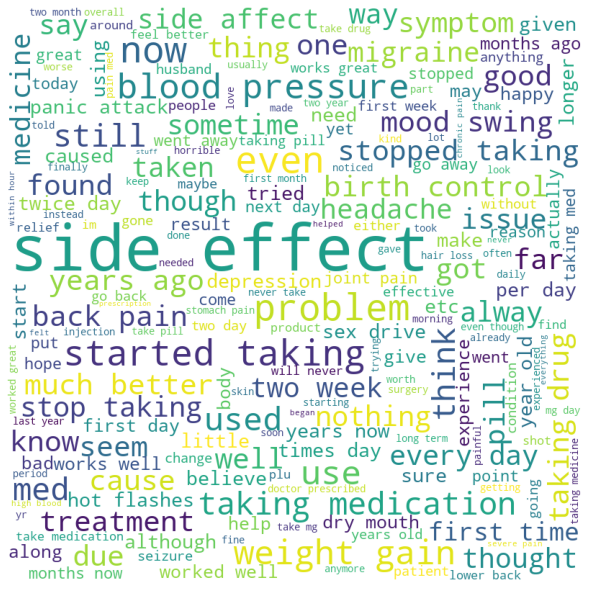

In [0]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Extracting entities for a custom entity by training a model in SpaCy

In [0]:
df_train.shape


(243080, 12)

In [0]:
drug_list = df_train['drug'].value_counts().index.tolist()
drug_list = [x.lower() for x in drug_list]

SpaCy recognizes the following built-in entity types:
PERSON - People, including fictional.

NORP - Nationalities or religious or political groups.

FAC - Buildings, airports, highways, bridges, etc.

ORG - Companies, agencies, institutions, etc.

GPE - Countries, cities, states.

LOC - Non-GPE locations, mountain ranges, bodies of water.

PRODUCT - Objects, vehicles, foods, etc. (Not services.)

EVENT - Named hurricanes, battles, wars, sports events, etc.

WORK_OF_ART - Titles of books, songs, etc.

LAW - Named documents made into laws.

LANGUAGE - Any named language.

DATE - Absolute or relative dates or periods.

TIME - Times smaller than a day.

PERCENT - Percentage, including "%".

MONEY - Monetary values, including unit.

QUANTITY - Measurements, as of weight or distance.

ORDINAL - "first", "second", etc.

CARDINAL - Numerals that do not fall under another type.

**Along with these built in types, SpaCy NER can be trained to recognize drug names as new entity 'DRUG'.**

In [0]:
import en_core_web_sm


In [0]:
!python -m spacy download en_core_web_sm

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: thinc.extra.search.Beam size changed, may indicate binary incompatibility. Expected 112 from C header, got 120 from PyObject
  return f(*args, **kwds)
     |████████████████████████████████| 11.1MB 548kB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.1.0a7-cp36-none-any.whl size=11050721 sha256=20b08dd348c031b503358875ba65aceba752561fa3fd526d87a47ff94091b292
  Stored in directory: /tmp/pip-ephem-wheel-cache-jx_4iblu/wheels/df/05/07/8b7d6d22079a9d9e2457d75bc18bb504e3af6325f2eb42ec04
Successfully built en-core-web-sm
  Found existing installation: en-core-web-sm 2.2.0
    Uninstalling en-core-web-sm-2.2.0:
      Successfully uninstalled en-core-web-sm-2.2.0
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [0]:
#First let's check some NERs in first 10 reviews and remove date, time, ordinal and cardinal.
nlp = spacy.load('en_core_web_sm')
count = 0
for review in df_train['reviews']:
    if count < 11:
        doc = nlp(review)
        ents = [(e.text, e.label_) for e in doc.ents if e.label_ not in ('DATE', 'TIME', 'ORDINAL', 'CARDINAL')]
        print(ents)
    count += 1

[]
[]
[('Lamictal', 'PERSON'), ('Abilify', 'PERSON'), ('5 pounds', 'QUANTITY')]
[('Lexapro', 'ORG'), ('Prozac', 'ORG')]
[]
[]
[]
[]
[]
[]
[('about 30 pounds', 'QUANTITY'), ('DD', 'ORG'), ('Balziva', 'ORG'), ('Balziva', 'ORG')]


If we see the above entity extraction by built-in entities, we do not get proper extraction. So let's train the NER with custom data for DRUG.

Training SpaCy NER for DRUG

In [0]:
def process_review(review):
    processed_token = []
    for token in str(review).split():
        token = ''.join(e.lower() for e in token if e.isalnum())
        processed_token.append(token)
    return ' '.join(processed_token)

In [0]:
#Step 1: Let's create the training data
count = 0
TRAIN_DATA = []
for _, item in df_train.iterrows():
    ent_dict = {}
    if count < 1000:
        review = process_review(item['reviews'])
        #We will find a drug and its positions once and add to the visited items.
        visited_items = []
        entities = []
        for token in review.split():
            if token in drug_list:
                for i in re.finditer(token, review):
                    if token not in visited_items:
                        entity = (i.span()[0], i.span()[1], 'DRUG')
                        visited_items.append(token)
                        entities.append(entity)
        if len(entities) > 0:
            ent_dict['entities'] = entities
            train_item = (review, ent_dict)
            TRAIN_DATA.append(train_item)
            count+=1

In [0]:
n_iter = 10
def train():
    nlp = spacy.blank("en")  # create blank Language class
    print("Created blank 'en' model")
    
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
        
    # add labels
    for _, annotations in TRAIN_DATA:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])
            
    nlp.begin_training()
    for itn in range(n_iter):
        random.shuffle(TRAIN_DATA)
        losses = {}
        # batch up the examples using spaCy's minibatch
        batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(
                texts,  # batch of texts
                annotations,  # batch of annotations
                drop=0.5,  # dropout - make it harder to memorise data
                losses=losses,
            )
        print("Losses", losses)
    return nlp

In [0]:
#Step 2: Let's train custom model with the training data
nlp2 = train()

Created blank 'en' model
Losses {'ner': 3117.9783502305545}
Losses {'ner': 1222.4803006225848}
Losses {'ner': 1013.7688402726674}
Losses {'ner': 921.4068875052362}
Losses {'ner': 899.5475681597353}
Losses {'ner': 830.4060156596248}
Losses {'ner': 844.6576747757398}
Losses {'ner': 751.5946477393006}
Losses {'ner': 806.4084414822225}
Losses {'ner': 714.5760116255141}


In [0]:
#Test the model
for text, _ in TRAIN_DATA[:10]:
    doc = nlp2(text)
    print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

Entities [('oxycontin', 'DRUG'), ('norco', 'DRUG'), ('tylenol', 'DRUG'), ('norco', 'DRUG')]
Entities [('ritalin', 'DRUG')]
Entities [('prednisone', 'DRUG')]
Entities [('lamictal', 'DRUG'), ('lamictal', 'DRUG'), ('lamictal', 'DRUG')]
Entities [('cough', 'DRUG')]
Entities [('savella', 'DRUG'), ('savella', 'DRUG'), ('savella', 'DRUG'), ('savella', 'DRUG'), ('savella', 'DRUG')]
Entities [('seroquel', 'DRUG'), ('prozac', 'DRUG')]
Entities [('aviane', 'DRUG')]
Entities [('trinessa', 'DRUG')]
Entities [('altavera', 'DRUG')]


In [0]:
test_reviews = df_train.iloc[-300:, :]['reviews']
for review in test_reviews:
    review = process_review(review)
    print(review)
    doc = nlp2(review)
    print("Entities", [(ent.text, ent.label_) for ent in doc.ents])
    print('________________________')

my arms ache when im trying to sleep
Entities []
________________________
lost weight caused some gi trouble was on a low dose because a higher dose caused fluid retention did help but was taken off because of gi trouble
Entities []
________________________
i was very happy the first time i took this medication one year ago now i have to take it again for the same problem im a pediatric nurse and work with many sick children and this medication is great
Entities []
________________________
i have 7 yeas on methodone  now im detoxing off of 24mg a day  the rate of 1mg every week you are not giving me the answers i needwhats methodone made of when was it made and does it matter how you take it
Entities [('methodone', 'DRUG')]
________________________
many side effects appeared
Entities []
________________________
basically felt needed an multivitamin more suited to my needs then taking an multivitamin and taking something besides that
Entities []
________________________
i am only 19 yea

**Conclusion for Entity Extraction with SpaCy**
We get some satisfying results in recognising the name of the drug if it's been metioned. This feature would be useful if the patient has written in her/his review that there have been some contraindications or improvement thanks to a combination with another 'DRUG' entuty. It can be useful in recomendation systems as well. But, we can also notice that there are some mislabeled entities, for example the noun 'cough' is labeled as 'DRUG' entity when it is clear that is not the case.